<a href="https://colab.research.google.com/github/AndrewstheBuilder/FromScratch_NeuralNetworks/blob/main/MultiLayerPerceptron_FromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

(80, 2) (20, 2) (80,) (20,)


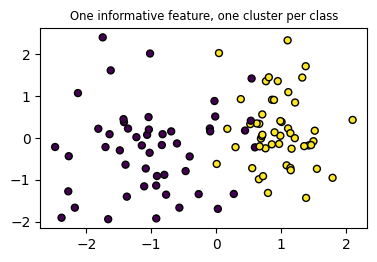

In [5]:
# Display Dataset to Train

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

plt.subplot(321)
plt.title("One informative feature, one cluster per class", fontsize="small")
X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1
)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

# Import Dataset to Train
train_length = int(len(X1) * 0.8)
test_length = len(X1) - train_length
train_x, test_x, train_y, test_y = X1[0:train_length], X1[train_length:], Y1[0:train_length], Y1[train_length:]
# print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

In [7]:
# Multi Layer Perceptron Implementation
class Neuron:
  def __init__(self, weights, bias):
    self.weights = weights
    self.bias = bias

  def feedforward(self, inputs):
    total = np.dot(self.weights, inputs) + self.bias
    return total

class MLP:
  def __init__():
    '''
    '''
    pass

  def train():
    '''
    '''
    pass

  def predict():
    '''
    '''
    pass

# First Attempt at solving this dataset with MLP

- I can attempt to solve this as a regression problem first
- Take in X and try to predict the Y for the 100 examples of [Xi, Yi] that I have
- And after that I can try it as a classification problem

In [9]:
weights = [0,0]
bias = 0
n = Neuron(weights, bias)
# print(n)